True


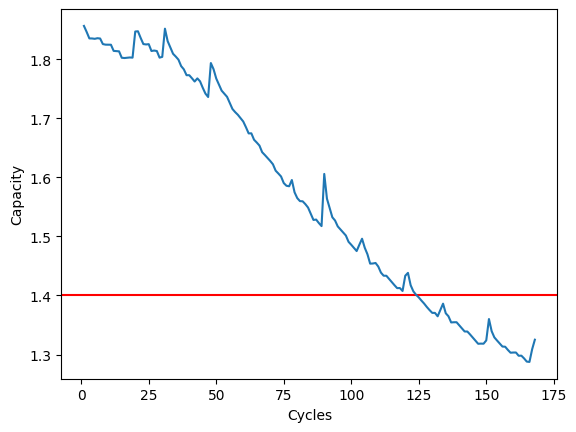

In [11]:
#DATESET FROM https://www.vertica.com/python/examples/battery/
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LeakyReLU
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
from math import sqrt
data_path = '/Users/Admin/Downloads/battery5_data.csv'

Battery= pd.read_csv(data_path)
time= Battery.loc[:, ['start_time']]
df= Battery
USE_CUDA = torch.cuda.is_available()

device = "cuda" if USE_CUDA else "cpu"

from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

data_path = '/Users/Admin/Downloads/battery5_data.csv'
Battery= pd.read_csv(data_path)
time= Battery.loc[:, ['start_time']]
df= Battery
import pandas as pd
data_path = '/Users/Admin/Downloads/battery5_data.csv'

isExist = os.path.exists(data_path)
print(isExist)
Battery= pd.read_csv(data_path)
time= Battery.loc[:, ['start_time']]
df= Battery#%%

import pandas as pd
from datetime import datetime
#df['start_time']=pd.to_datetime(df['start_time'], format='%Y%m%d:%H:%M:%S')
df['start_time']=pd.to_datetime(df['start_time'], format='ISO8601')
dff = df.sort_values('start_time')

discharge= dff.loc[dff['type'] == 'discharge']
charge= dff.loc[dff['type'] == 'charge']
d_cap= discharge.loc[:, ['start_time', 'Capacity']]
cycles= (d_cap['Capacity'].ne(d_cap['Capacity'].shift())).cumsum()
plt.axhline(y=0.7*2, color='r', linestyle='-')
plt.plot(cycles, d_cap['Capacity'])
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.show()

Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_charge          0
Voltage_charge          0
Time                    0
Capacity                0
cycles                  0
V/t                     0
Vt                      0
VT                      0
V/T                     0
dtype: int64
Voltage_measured          0
Current_measured          0
Temperature_measured      0
Current_charge            0
Voltage_charge            0
Time                      0
Capacity                  0
cycles                    0
V/t                     168
Vt                        0
VT                        0
V/T                       0
dtype: int64


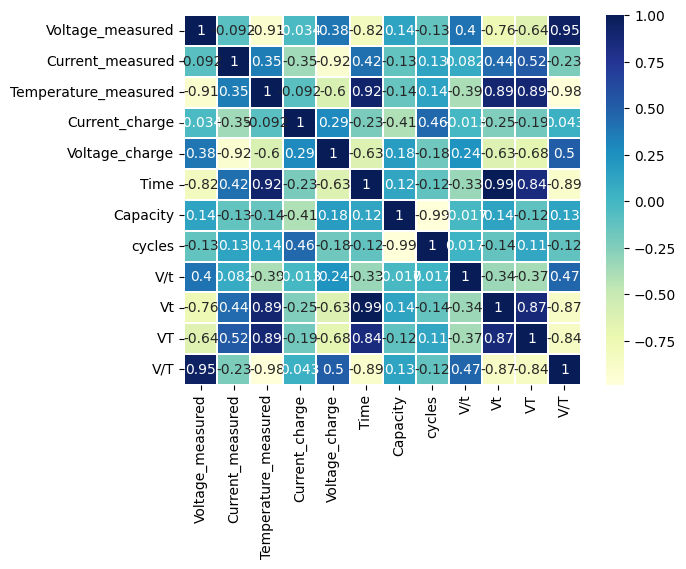

In [12]:
f_charge= charge.drop(columns =['start_time', 'type', 'ambient_temp', 'Capacity'])
f_discharge= discharge.drop(columns =['start_time', 'type', 'ambient_temp'])
f_discharge['cycles']= cycles
f_discharge['V/t']=f_discharge['Voltage_measured']/f_discharge['Time']
f_discharge['Vt']=f_discharge['Voltage_measured']*f_discharge['Time']
f_discharge['VT']=f_discharge['Voltage_measured']*f_discharge['Temperature_measured']
f_discharge['V/T']=f_discharge['Voltage_measured']/f_discharge['Temperature_measured']
import seaborn as sns
sns.heatmap(f_discharge.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);
print(f_discharge.isnull().sum()) #null
print(f_discharge.isin([np.inf, -np.inf]).sum()) #infinity

In [13]:
#clean and replace
f_discharge.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
f_discharge.dropna(inplace=True)
print(f_discharge.isin([np.inf, -np.inf]).sum())

Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_charge          0
Voltage_charge          0
Time                    0
Capacity                0
cycles                  0
V/t                     0
Vt                      0
VT                      0
V/T                     0
dtype: int64


In [14]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

np.random.seed(5)

In [15]:
# take predicted variable
all_y = f_discharge['Capacity'].values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape
#look_back = 240
look_back = 16
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back))) #50
model.add(Dropout(0.1)) #0.1 or 0.2
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#history= model.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=1)
history = model.fit(trainX, trainY, epochs=1000, batch_size=240, validation_data=(testX, testY), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/1000
147/147 [==============================] - 10s 20ms/step - loss: 0.0677 - val_loss: 0.0019
Epoch 2/1000
147/147 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 3/1000
147/147 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 4/1000
147/147 [==============================] - 1s 8ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 5/1000
147/147 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 8.4478e-04
Epoch 6/1000
147/147 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 7.5027e-04
Epoch 7/1000
147/147 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 6.6320e-04
Epoch 8/1000
147/147 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 5.9869e-04
Epoch 9/1000
147/147 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 5.7213e-04
Epoch 10/1000
147/147 [==============================] - 1s

In [17]:
import math

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

print('test Capacity:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

print('testPredictions:')
print(testPredict)

470/470 [==============================] - 2s 4ms/step
Train Score: 0.0197 RMSE
Test Score: 0.0145 RMSE
test Capacity:
testPredictions:
[[1.4080358]
 [1.4080358]
 [1.4080358]
 ...
 [1.3414047]
 [1.3414047]
 [1.3414047]]


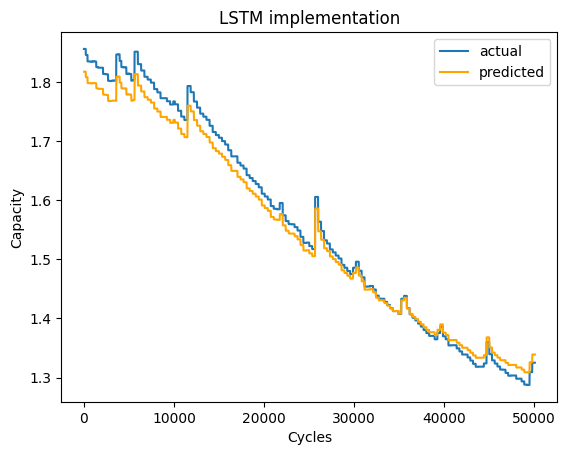

In [9]:
# plot final predictions

plt.plot(scaler.inverse_transform(dataset), label= 'actual')
plt.plot(trainPredictPlot, color= 'orange', label= 'predicted')
plt.plot(testPredictPlot, color= 'orange')
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('LSTM implementation')
plt.legend()

In [18]:
from sklearn.metrics import r2_score

print('Test Score: %.4f RMSE' % (math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))))
( testY[0]- testPredict[:,0])/testY[0]
print('Test Score: %.4f MAE' % mean_absolute_error(testY[0], testPredict[:,0]))
print('Coefficient of determination: %.4f R2' % r2_score(testY[0], testPredict[:,0]))

Test Score: 0.0145 RMSE
Test Score: 0.0126 MAE
Coefficient of determination: 0.8596 R2
